# Predict the Cost of Homes in California Using SageMaker Studio

In [127]:
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [128]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

# Get the data from SageMaker Feature Store

In [129]:
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

feature_group_name = "FG-ndcDay-eeb28445" # replace with your feature group name 
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

In [130]:
# Build SQL query to features group
fs_query = feature_group.athena_query()
fs_table = fs_query.table_name
query_string = 'SELECT * FROM "'+fs_table+'"'
print('Running ' + query_string)

Running SELECT * FROM "fg-ndcday-eeb28445-1673227521"


In [131]:
# Run Athena query. The output is loaded to a Pandas dataframe.
fs_query.run(query_string=query_string, output_location='s3://'+bucket+'/'+prefix+'/fs_query_results/')
fs_query.wait()
model_data = fs_query.as_dataframe()

In [132]:
model_data

,housing_median_age,median_income,median_house_value,ocean_proximity__1h_ocean,ocean_proximity_inland,ocean_proximity_near_ocean,ocean_proximity_near_bay,ocean_proximity_island,rooms_per_household,bedrooms_per_room,population_per_household,coords,write_time,api_invocation_time,is_deleted
0,14.0,2.8588,92500.0,1.0,0.0,0.0,0.0,0.0,3.877088,0.288396,2.301909,-3.559878,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
1,16.0,2.9576,92200.0,0.0,0.0,1.0,0.0,0.0,3.613357,0.306907,1.488576,-3.574916,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
2,15.0,1.6348,93200.0,0.0,0.0,1.0,0.0,0.0,3.404321,0.293744,3.875000,-3.595699,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
3,13.0,1.6667,78800.0,0.0,0.0,1.0,0.0,0.0,4.015924,0.285091,2.199045,-3.032999,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
4,28.0,2.4559,75600.0,1.0,0.0,0.0,0.0,0.0,4.681529,0.228571,2.582803,-3.032771,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,36.0,8.1586,404300.0,0.0,0.0,0.0,1.0,0.0,6.954451,0.146770,2.687371,-3.226624,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
20636,30.0,6.8198,493800.0,0.0,0.0,1.0,0.0,0.0,5.825175,0.196879,2.503497,-3.239630,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
20637,21.0,4.3125,495800.0,0.0,0.0,1.0,0.0,0.0,11.380000,0.194025,2.396000,-3.239440,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False
20638,38.0,4.1304,433300.0,1.0,0.0,0.0,0.0,0.0,4.124413,0.264087,1.927230,-3.511177,2023-01-09 01:31:39.525,2023-01-09 01:31:39.525,False


In [133]:
#remove unwanted columns
model_data = model_data.drop(['write_time', 'api_invocation_time', 'is_deleted'], axis=1)

In [134]:
model_data

,housing_median_age,median_income,median_house_value,ocean_proximity__1h_ocean,ocean_proximity_inland,ocean_proximity_near_ocean,ocean_proximity_near_bay,ocean_proximity_island,rooms_per_household,bedrooms_per_room,population_per_household,coords
0,14.0,2.8588,92500.0,1.0,0.0,0.0,0.0,0.0,3.877088,0.288396,2.301909,-3.559878
1,16.0,2.9576,92200.0,0.0,0.0,1.0,0.0,0.0,3.613357,0.306907,1.488576,-3.574916
2,15.0,1.6348,93200.0,0.0,0.0,1.0,0.0,0.0,3.404321,0.293744,3.875000,-3.595699
3,13.0,1.6667,78800.0,0.0,0.0,1.0,0.0,0.0,4.015924,0.285091,2.199045,-3.032999
4,28.0,2.4559,75600.0,1.0,0.0,0.0,0.0,0.0,4.681529,0.228571,2.582803,-3.032771
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,36.0,8.1586,404300.0,0.0,0.0,0.0,1.0,0.0,6.954451,0.146770,2.687371,-3.226624
20636,30.0,6.8198,493800.0,0.0,0.0,1.0,0.0,0.0,5.825175,0.196879,2.503497,-3.239630
20637,21.0,4.3125,495800.0,0.0,0.0,1.0,0.0,0.0,11.380000,0.194025,2.396000,-3.239440
20638,38.0,4.1304,433300.0,1.0,0.0,0.0,0.0,0.0,4.124413,0.264087,1.927230,-3.511177


In [135]:
# Prepare data SageMaker's XGBoost
# Amazon SageMaker's XGBoost container expects data in CSV data format. 
# Note that the first column must be the target variable and the CSV should not include headers. 

# move target (ie, median_house_value) to first column
model_data2=model_data.reindex(columns= ['median_house_value', 'housing_median_age', 'median_income', 'ocean_proximity__1h_ocean',
                                         'ocean_proximity_inland','ocean_proximity_near_ocean', 'ocean_proximity_near_bay', 'ocean_proximity_island', 
                                         'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'coords'])
model_data2



,median_house_value,housing_median_age,median_income,ocean_proximity__1h_ocean,ocean_proximity_inland,ocean_proximity_near_ocean,ocean_proximity_near_bay,ocean_proximity_island,rooms_per_household,bedrooms_per_room,population_per_household,coords
0,92500.0,14.0,2.8588,1.0,0.0,0.0,0.0,0.0,3.877088,0.288396,2.301909,-3.559878
1,92200.0,16.0,2.9576,0.0,0.0,1.0,0.0,0.0,3.613357,0.306907,1.488576,-3.574916
2,93200.0,15.0,1.6348,0.0,0.0,1.0,0.0,0.0,3.404321,0.293744,3.875000,-3.595699
3,78800.0,13.0,1.6667,0.0,0.0,1.0,0.0,0.0,4.015924,0.285091,2.199045,-3.032999
4,75600.0,28.0,2.4559,1.0,0.0,0.0,0.0,0.0,4.681529,0.228571,2.582803,-3.032771
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,404300.0,36.0,8.1586,0.0,0.0,0.0,1.0,0.0,6.954451,0.146770,2.687371,-3.226624
20636,493800.0,30.0,6.8198,0.0,0.0,1.0,0.0,0.0,5.825175,0.196879,2.503497,-3.239630
20637,495800.0,21.0,4.3125,0.0,0.0,1.0,0.0,0.0,11.380000,0.194025,2.396000,-3.239440
20638,433300.0,38.0,4.1304,1.0,0.0,0.0,0.0,0.0,4.124413,0.264087,1.927230,-3.511177


In [136]:
# remove the headers
model_data2.columns = range(model_data2.shape[1])   # Delete headers

model_data2

,0,1,2,3,4,5,6,7,8,9,10,11
0,92500.0,14.0,2.8588,1.0,0.0,0.0,0.0,0.0,3.877088,0.288396,2.301909,-3.559878
1,92200.0,16.0,2.9576,0.0,0.0,1.0,0.0,0.0,3.613357,0.306907,1.488576,-3.574916
2,93200.0,15.0,1.6348,0.0,0.0,1.0,0.0,0.0,3.404321,0.293744,3.875000,-3.595699
3,78800.0,13.0,1.6667,0.0,0.0,1.0,0.0,0.0,4.015924,0.285091,2.199045,-3.032999
4,75600.0,28.0,2.4559,1.0,0.0,0.0,0.0,0.0,4.681529,0.228571,2.582803,-3.032771
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,404300.0,36.0,8.1586,0.0,0.0,0.0,1.0,0.0,6.954451,0.146770,2.687371,-3.226624
20636,493800.0,30.0,6.8198,0.0,0.0,1.0,0.0,0.0,5.825175,0.196879,2.503497,-3.239630
20637,495800.0,21.0,4.3125,0.0,0.0,1.0,0.0,0.0,11.380000,0.194025,2.396000,-3.239440
20638,433300.0,38.0,4.1304,1.0,0.0,0.0,0.0,0.0,4.124413,0.264087,1.927230,-3.511177


In [265]:
# separate data into train/test data split

#The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy 
#we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(model_data2.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(model_data2)), int(0.9 * len(model_data2))]) 

In [138]:
# train data to CSV
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)

In [139]:
#copy data to S3 for SageMaker to access
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

# Training

In [140]:
#specify the ECR container location for Amazon SageMaker's implementation of XGBoost

container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [141]:
#Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use 
# as a pointer to the files in S3, which also specify that the content type is CSV.
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator. This includes:

The xgboost algorithm container
The IAM role to use
Training instance type and count
S3 location for output data
Algorithm hyperparameters
And then a .fit() function which specifies:

S3 location for output data. In this case we have both a training and validation set which are passed in.

In [142]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5, #The maximum depth per tree. A deeper tree might increase the performance, 
                                     #but also the complexity and chances to overfit.
                        eta=0.2, #learning rate
                        gamma=4, #Gamma is a pseudo-regularisation parameter (Lagrangian multiplier), and depends on the other parameters. 
                                 #The higher Gamma is, the higher the regularization.
                        min_child_weight=6,
                        subsample=0.8, #Represents the fraction of observations to be sampled for each tree. 
                                       #A lower values prevent overfitting but might lead to under-fitting.
                        silent=0,
                        objective='reg:linear', #RMSE is the default metric for linear regression; 
                                                #The SageMaker XGBoost algorithm actually calculates RMSE and writes it to the 
                                                #CloudWatch logs on the data passed to the “validation” channel.
                        num_round=100 #number of trees)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2023-01-09 05:38:45 Starting - Starting the training job...
2023-01-09 05:39:10 Starting - Preparing the instances for trainingProfilerReport-1673242724: InProgress
.........
2023-01-09 05:40:29 Downloading - Downloading input data......
2023-01-09 05:41:29 Training - Downloading the training image..Arguments: train
[2023-01-09:05:41:58:INFO] Running standalone xgboost training.
[2023-01-09:05:41:58:INFO] File size need to be processed in the node: 2.02mb. Available memory size in the node: 8622.46mb
[2023-01-09:05:41:58:INFO] Determined delimiter of CSV input is ','
[05:41:58] S3DistributionType set as FullyReplicated
[05:41:58] 14447x11 matrix with 158917 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-01-09:05:41:58:INFO] Determined delimiter of CSV input is ','
[05:41:58] S3DistributionType set as FullyReplicated
[05:41:58] 4129x11 matrix with 45419 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[05:4

# Model Hosting w/ Endpoint Creation & Model Evaluation
Now that we have successfully trained our model, let’s deploy it and see how it does on the test data!

In [148]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

----------!

In [179]:
#need to make sure data is in correct format for deployed model
from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()
xgb_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [266]:
test_data

,0,1,2,3,4,5,6,7,8,9,10,11
1459,104000.0,26.0,2.5179,0.0,1.0,0.0,0.0,0.0,5.334174,0.194563,3.517024,-3.403054
13935,266200.0,52.0,3.2448,0.0,0.0,0.0,1.0,0.0,5.487805,0.178519,3.056911,-3.245428
6843,187500.0,32.0,2.4306,1.0,0.0,0.0,0.0,0.0,4.004032,0.287009,4.209677,-3.461404
17103,500001.0,52.0,8.0095,1.0,0.0,0.0,0.0,0.0,6.252577,0.159934,2.592784,-3.475925
2286,136200.0,37.0,2.6618,0.0,0.0,0.0,1.0,0.0,3.874172,0.258974,2.536424,-3.194096
...,...,...,...,...,...,...,...,...,...,...,...,...
13379,174300.0,21.0,4.8051,0.0,1.0,0.0,0.0,0.0,5.857143,0.179847,2.704185,-3.103590
11646,253500.0,15.0,5.5148,1.0,0.0,0.0,0.0,0.0,5.706783,0.175613,3.350109,-3.297913
1267,72500.0,36.0,2.4044,0.0,1.0,0.0,0.0,0.0,5.438449,0.196899,3.430017,-3.333240
3174,61600.0,30.0,2.4412,0.0,1.0,0.0,0.0,0.0,5.441026,0.216777,4.364103,-3.198312


In [269]:
# axis where 1 is the axis number (0 for rows and 1 for columns.)
# To delete the column without having to reassign df you can do - inplace = False

test_data_median_house_value_column = test_data.drop(columns=test_data.columns[[1,2,3,4,5,6,7,8,9,10,11]], axis=1, inplace=False)

test_data_median_house_value_column

,0
1459,104000.0
13935,266200.0
6843,187500.0
17103,500001.0
2286,136200.0
...,...
13379,174300.0
11646,253500.0
1267,72500.0
3174,61600.0


In [270]:
#drop first column of test data, the first column shouldn't be the target
test_data.drop(columns=test_data.columns[0], axis=1, inplace=True)

In [271]:
test_data

,1,2,3,4,5,6,7,8,9,10,11
1459,26.0,2.5179,0.0,1.0,0.0,0.0,0.0,5.334174,0.194563,3.517024,-3.403054
13935,52.0,3.2448,0.0,0.0,0.0,1.0,0.0,5.487805,0.178519,3.056911,-3.245428
6843,32.0,2.4306,1.0,0.0,0.0,0.0,0.0,4.004032,0.287009,4.209677,-3.461404
17103,52.0,8.0095,1.0,0.0,0.0,0.0,0.0,6.252577,0.159934,2.592784,-3.475925
2286,37.0,2.6618,0.0,0.0,0.0,1.0,0.0,3.874172,0.258974,2.536424,-3.194096
...,...,...,...,...,...,...,...,...,...,...,...
13379,21.0,4.8051,0.0,1.0,0.0,0.0,0.0,5.857143,0.179847,2.704185,-3.103590
11646,15.0,5.5148,1.0,0.0,0.0,0.0,0.0,5.706783,0.175613,3.350109,-3.297913
1267,36.0,2.4044,0.0,1.0,0.0,0.0,0.0,5.438449,0.196899,3.430017,-3.333240
3174,30.0,2.4412,0.0,1.0,0.0,0.0,0.0,5.441026,0.216777,4.364103,-3.198312


# Inference

In [211]:
# run the prediction on a single observation
prediction = xgb_predictor.predict(np.array([26.0, 2.5179, 0.0, 1.0, 0.0, 0.0, 0.0, 5.334174, 0.194563, 3.517024, -3.403054]))
prediction

82192.7734375

In [254]:
#run predictions on the entire test data set

def predict(data, predictor, rows=500 ):
    #splits test dataset into 5 arrays of observations
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    
    for array in split_array:
        for observation in array:
            prediction = predictor.predict(observation)
            predictions = ','.join([predictions, str(prediction)])
            
    return np.fromstring(predictions[1:], sep=',')

#numpy array of predictions
predictions = predict(test_data.to_numpy(), xgb_predictor)
print(predictions)

[ 82192.7734375  264557.125      152053.6875     ...  75169.15625
  90198.9921875   52055.90234375]


In [261]:
print(predictions[0])

82192.7734375


In [262]:
print(predictions[1])

264557.125


In [263]:
print(predictions[2])

152053.6875


In [340]:
# convert DF to 1-dimensional array for easy comparison
test_data_median_house_value_column_array = test_data_median_house_value_column.values.flatten()

# Default value of display.max_rows is 10 so at max
# 10 rows will be printed. Set it None to display
# all rows in the dataframe
pd.set_option('display.max_rows', None)

comparison_df = pd.DataFrame({'Actual': test_data_median_house_value_column_array, 'Predicted': predictions})

# Turn on output cell scrolling
# Cell>Enable Scrolling for outputs
comparison_df

,Actual,Predicted
0,104000.0,82192.773438
1,266200.0,264557.125000
2,187500.0,152053.687500
3,500001.0,493417.375000
4,136200.0,129654.046875
5,286100.0,251638.171875
6,134500.0,171915.953125
7,334100.0,247425.062500
8,241400.0,186607.921875
9,59000.0,98117.664062


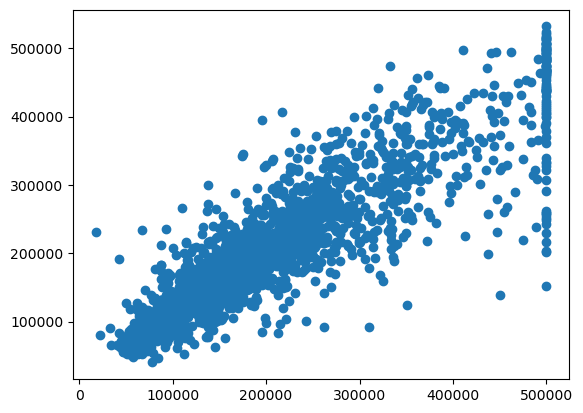

In [351]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.scatter(test_data_median_house_value_column, predictions, c=test_data_median_house_value_column, cmap='gray')
plt.scatter(test_data_median_house_value_column_array, predictions)

# Calculate R^2 Metric

In [352]:
from sklearn import metrics 

#R^2
r2 = round(metrics.r2_score(test_data_median_house_value_column_array, predictions),2)
print("R^2: {}".format(r2))

R^2: 0.79


# Challenge 1

## Automatic Model Tuning (ie, hyperparameter tuning)
Automatic model tuning finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. 

Tunable parameters for XGBoost: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html; not every hyperparameter is tunable

In [403]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0.1, 1),
                         'max_depth': IntegerParameter(10, 20),
                         'subsample': ContinuousParameter(0.5, 1),
                         'min_child_weight': IntegerParameter(5, 15),
                         'gamma': ContinuousParameter(0.1, 1)}

In [407]:
objective_metric_name = 'validation:rmse'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'rmse', 'Regex': 'rmse: ([0-9\.]+)'}]

In [408]:
tuner = HyperparameterTuner(xgb,
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3,
                            objective_type=objective_type,
                            objective_metric_name=objective_metric_name,
                            metric_definitions=metric_definitions)

In [409]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

................................................................................................................!


In [410]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [411]:
# return the best training job name
tuner.best_training_job()

'xgboost-230112-0245-017-2b5ae01e'

In [412]:
# Deploy the best trained or user specified model to an Amazon SageMaker endpoint
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')


2023-01-12 02:54:06 Starting - Found matching resource for reuse
2023-01-12 02:54:06 Downloading - Downloading input data
2023-01-12 02:54:06 Training - Training image download completed. Training in progress.
2023-01-12 02:54:06 Uploading - Uploading generated training model
2023-01-12 02:54:06 Completed - Resource reused by training job: xgboost-230112-0245-020-fd0f8f5b
-------!

In [413]:
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()
tuner_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [414]:
#numpy array of predictions
tuner_predictions = predict(test_data.to_numpy(), tuner_predictor)
print(tuner_predictions)

[ 90953.140625 255949.453125 154774.515625 ...  67363.921875  95768.03125
  67557.78125 ]


In [415]:
tuner_comparison_df = pd.DataFrame({'Actual': test_data_median_house_value_column_array, 'Predicted': tuner_predictions})

# Turn on output cell scrolling
# Cell>Enable Scrolling for outputs
tuner_comparison_df

,Actual,Predicted
0,104000.0,90953.140625
1,266200.0,255949.453125
2,187500.0,154774.515625
3,500001.0,491897.593750
4,136200.0,136043.015625
5,286100.0,283848.218750
6,134500.0,165061.718750
7,334100.0,253363.234375
8,241400.0,178837.906250
9,59000.0,96252.843750


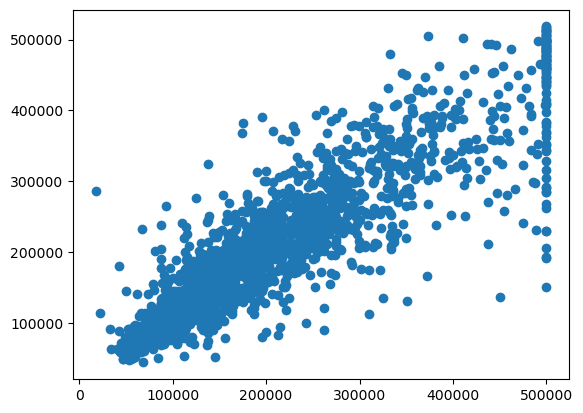

In [416]:
plt.scatter(test_data_median_house_value_column_array, tuner_predictions)

In [417]:
r2 = round(metrics.r2_score(test_data_median_house_value_column_array, tuner_predictions),2)
print("R^2: {}".format(r2))

R^2: 0.8


# Clean-up
If you’re ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [418]:
xgb_predictor.delete_endpoint()

In [419]:
tuner_predictor.delete_endpoint(delete_endpoint_config=True)